# Fack Data
데이터가 많을 수록 generalize를 더 잘할 수 있음.  
데이터 많이 갖는 방법 중 하나는 이미 가지고 있는 데이터를 사용하는 것임.
  
**augmentation**한다는 것은 자동차의 왼쪽이나 오른쪽 부분을 찍은 사진이 각각 있어도 결국에 이것들이 다 "자동차"라는 사실은 변함이 없기때문에 classifier가 이러한 difference를 무시하도록 하는 방법이다.
  
random transformation applied -> the model is always seeing something a little different than what it's seen before. This extra variance in the training data is what helps the model on new data.
  
주의 사항 : Most importantly, whatever transformations you use should not mix up the classes. 

In [1]:
# Data pipeline ways
# 1. ImageDataGenerator
# 2. using Keras's preprocessing layers (CPU 대신 GPU로 computed)

# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    'input/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    'input/car-or-truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


In [10]:
# Model 설정
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


pretrained_base = tf.keras.models.load_model('input/cv-course-models/cv-course-models/vgg16-pretrained-base',)
pretrained_base.trainable = False

model = keras.Sequential([
    # Preprocessing
    preprocessing.RandomFlip('horizontal'), # flip left-to-right
    preprocessing.RandomContrast(0.5), # contrast change by up to 50%
    # Base(특징 추출한 베이스)
    pretrained_base,
    # Head(classify하는 부분)
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

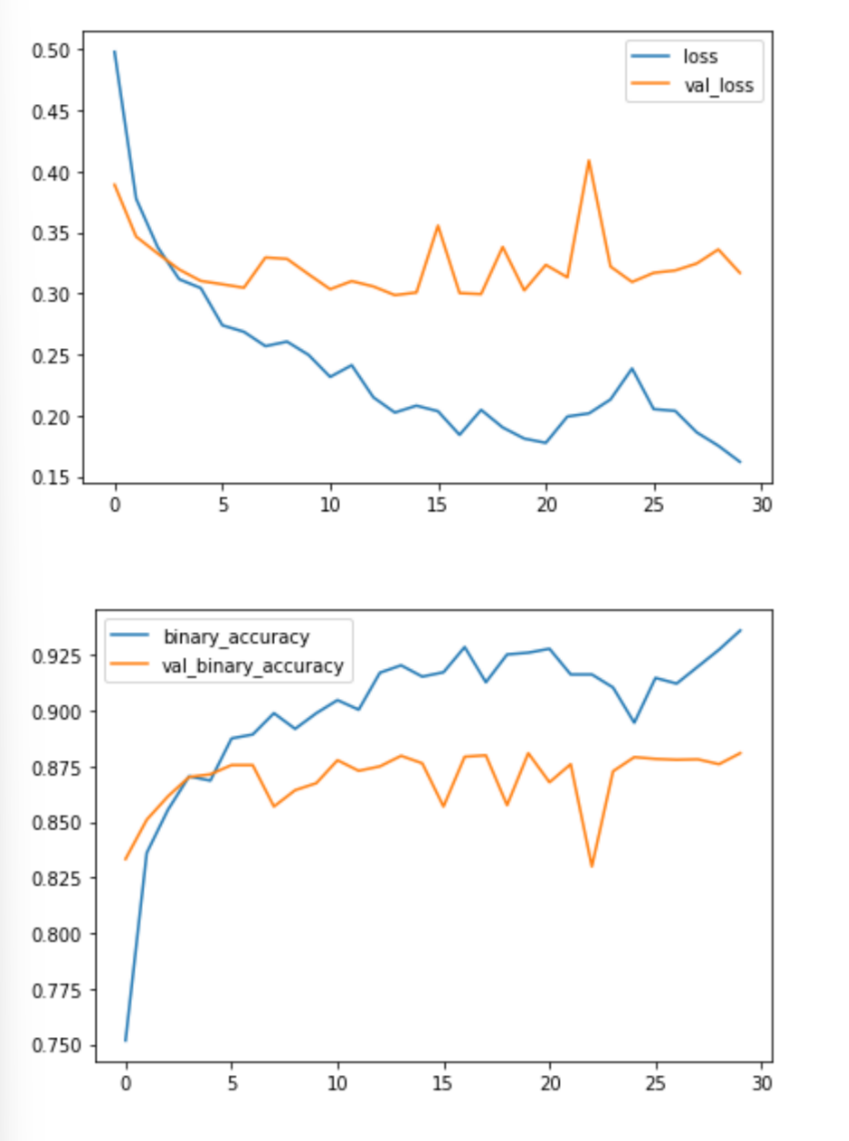